In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import torch
import torch.nn as nn

In [2]:
df = pd.read_csv('../Data/TimeSeriesData/Alcohol_Sales.csv',index_col=0,parse_dates=True)

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


<Axes: xlabel='DATE'>

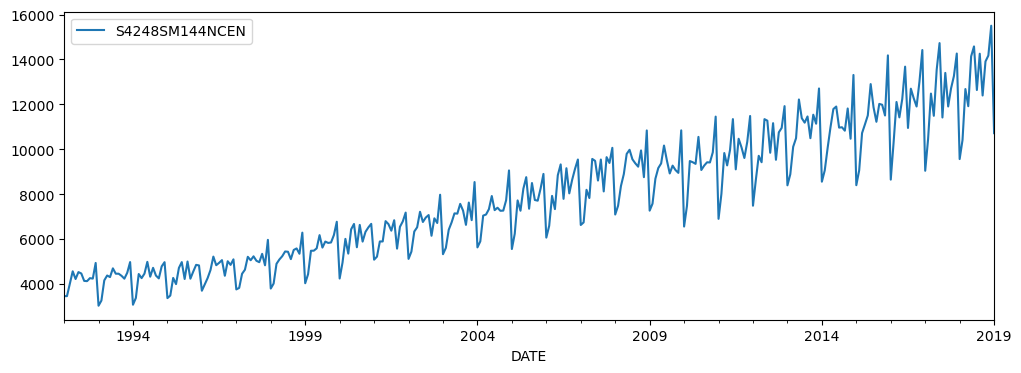

In [4]:
df.plot(figsize=(12,4))

In [5]:
y = df['S4248SM144NCEN'].values.astype(float)

In [6]:
test_size = 12

In [7]:
train_size = len(y)- test_size

In [8]:
train_set = y[:train_size]
test_set = y[train_size:]

In [9]:
from sklearn.preprocessing import MinMaxScaler
sclr = MinMaxScaler(feature_range=(-1,1))

In [10]:
train_norm = torch.Tensor(sclr.fit_transform(train_set.reshape(-1,1))).view(-1)

In [11]:
train_norm

tensor([-0.9268, -0.9270, -0.8340, -0.7379, -0.7966, -0.7439, -0.7547, -0.8109,
        -0.8128, -0.7901, -0.7933, -0.6743, -1.0000, -0.9607, -0.8070, -0.7699,
        -0.7819, -0.7154, -0.7560, -0.7562, -0.7721, -0.7940, -0.7489, -0.6678,
        -0.9925, -0.9408, -0.7586, -0.7897, -0.7557, -0.6660, -0.7790, -0.7114,
        -0.7704, -0.7919, -0.7003, -0.6683, -0.9420, -0.9226, -0.7884, -0.8354,
        -0.7121, -0.6678, -0.7962, -0.6634, -0.7942, -0.7396, -0.6889, -0.6931,
        -0.8858, -0.8373, -0.7896, -0.7285, -0.6260, -0.6914, -0.6735, -0.6528,
        -0.7719, -0.6613, -0.6890, -0.6468, -0.8757, -0.8643, -0.7567, -0.7258,
        -0.6275, -0.6536, -0.6239, -0.6576, -0.6685, -0.6049, -0.6923, -0.4984,
        -0.8692, -0.8311, -0.6808, -0.6480, -0.6229, -0.5870, -0.5890, -0.6451,
        -0.5753, -0.5637, -0.6042, -0.4435, -0.8289, -0.7600, -0.5815, -0.5808,
        -0.5630, -0.4623, -0.5572, -0.5114, -0.5218, -0.5182, -0.4617, -0.3606,
        -0.7928, -0.6716, -0.4911, -0.60

In [12]:
def input_data(seq,window_size):
    L = len(seq)
    out = []
    for i in range(L-window_size):
        window = seq[i:i+window_size]
        label = seq[i+window_size:i+window_size+1]
        out.append((window,label))
    return out

In [13]:
window_size = 12
train_data = input_data(train_norm,window_size)

In [14]:
len(train_data)

301

In [15]:
#define model

In [16]:
class LSTM(nn.Module):
    
    def __init__(self,input_size=1,hidden_size=128,out_size=1,num_layers=1,bidirectional=False):
        super(LSTM,self).__init__()
        #attributes for the cell and hidden state
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_dir = 2 if bidirectional else 1
        self.hidden = (torch.zeros(self.num_layers * self.num_dir,1,hidden_size),
                      torch.zeros(self.num_layers * self.num_dir,1,hidden_size))
        self.lstm = nn.LSTM(input_size,hidden_size,num_layers,bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size * self.num_dir,out_size)
    
    def forward(self,seq):
        lstm_out,self.hidden = self.lstm(seq.view(len(seq),1,-1),self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]
    

In [17]:
model = LSTM()

In [18]:
model

LSTM(
  (lstm): LSTM(1, 128)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)

In [19]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
num_epochs = 200

In [20]:
import time
start = time.time()
for epoch in range(num_epochs):
    for seq,label in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size),
                      torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size))
        y_pred = model.forward(seq)
        loss = criterion(y_pred,label)
        loss.backward()
        optimizer.step()
    if (epoch+1)%10 == 0:
        print(f"epoch : {epoch+1}/{num_epochs} loss : {loss.item()}")
end = time.time()
print(end-start)

epoch : 10/200 loss : 0.27629178762435913
epoch : 20/200 loss : 0.06558672338724136
epoch : 30/200 loss : 0.05325350910425186
epoch : 40/200 loss : 0.02297387830913067
epoch : 50/200 loss : 0.002522785449400544
epoch : 60/200 loss : 5.005505227018148e-05
epoch : 70/200 loss : 0.0014083139831200242
epoch : 80/200 loss : 0.012178268283605576
epoch : 90/200 loss : 1.9643419364001602e-05
epoch : 100/200 loss : 0.009229461662471294
epoch : 110/200 loss : 0.0035897803027182817
epoch : 120/200 loss : 0.0042952075600624084
epoch : 130/200 loss : 0.004682574886828661
epoch : 140/200 loss : 0.004775687120854855
epoch : 150/200 loss : 0.002502210671082139
epoch : 160/200 loss : 0.003624617587774992
epoch : 170/200 loss : 0.004702886566519737
epoch : 180/200 loss : 0.003211334580555558
epoch : 190/200 loss : 0.014322425238788128
epoch : 200/200 loss : 0.0002075865922961384
80.87391996383667


In [21]:
preds = train_norm[-window_size:].tolist()

In [22]:
future = 12

In [23]:
model.eval()
for f in range(future):
    seq = torch.Tensor(preds[-window_size:])
    with torch.no_grad():
        
        model.hidden = (torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size),
                      torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size))
        preds.append(model.forward(seq).item())

In [24]:
#predictions
predictions = preds[window_size:]

In [25]:
true_prediction = sclr.inverse_transform(np.array(predictions).reshape(-1,1))

In [26]:
true_prediction

array([[12367.81459305],
       [13785.41640827],
       [12367.32089421],
       [15116.88904482],
       [15270.01099378],
       [12318.81986484],
       [15670.33729362],
       [12291.08417109],
       [13630.17671445],
       [13125.48994207],
       [14551.42641172],
       [16037.09625655]])

In [27]:
df['S4248SM144NCEN'][-12:]

DATE
2018-02-01    10415
2018-03-01    12683
2018-04-01    11919
2018-05-01    14138
2018-06-01    14583
2018-07-01    12640
2018-08-01    14257
2018-09-01    12396
2018-10-01    13914
2018-11-01    14174
2018-12-01    15504
2019-01-01    10718
Name: S4248SM144NCEN, dtype: int64

In [28]:
x = np.arange("2018-02-01","2019-02-01",dtype="datetime64[M]")

In [29]:
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

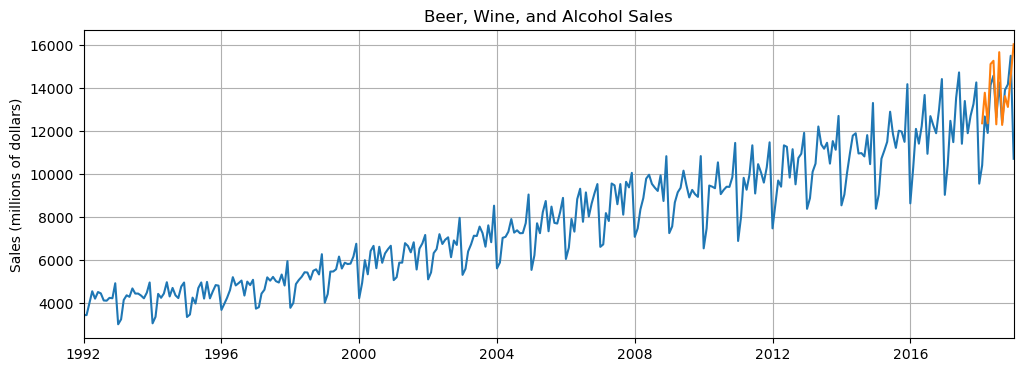

In [30]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_prediction)
plt.show()

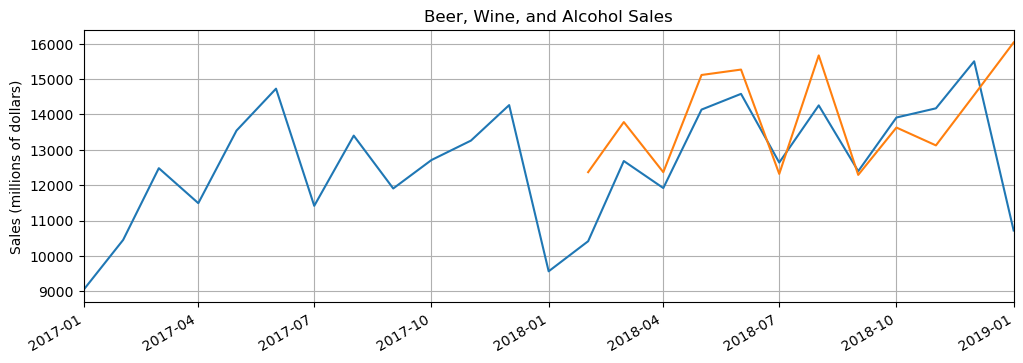

In [31]:
# Plot the end of the graph
fig = plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
fig.autofmt_xdate()

# Select the end of the graph with slice notation:
plt.plot(df['S4248SM144NCEN']['2017-01-01':])
plt.plot(x,true_prediction)
plt.show()

In [ ]:
#forcast into unknown future
num_epochs = 100
model.train()
y_norm = sclr.fit_transform(y.reshape(-1,1))
y_norm = torch.Tensor(y_norm).view(-1)
all_data = input_data(y_norm,window_size)
import time
start = time.time()
for epoch in range(num_epochs):
    for seq,label in all_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size),
                      torch.zeros(model.num_layers * model.num_dir,1,model.hidden_size))
        y_pred = model.forward(seq)
        loss = criterion(y_pred,label)
        loss.backward()
        optimizer.step()
    if (epoch+1)%10 == 0:
        print(f"epoch : {epoch+1}/{num_epochs} loss : {loss.item()}")
end = time.time()
print(end-start)
    

epoch : 10/100 loss : 0.024728093296289444
epoch : 20/100 loss : 0.0012850796338170767
epoch : 30/100 loss : 0.0065803867764770985


In [ ]:
window_size = 12
future = 12
L = len(y)

preds = y_norm[-window_size:].tolist()

model.eval()
for i in range(future):  
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        # Reset the hidden parameters here!
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))  
        preds.append(model.forward(seq).item())


In [ ]:
true_predictions = sclr.inverse_transform(np.array(preds).reshape(-1, 1))

In [ ]:
x = np.arange('2019-02-01', '2020-02-01', dtype='datetime64[M]').astype('datetime64[D]')

In [ ]:
true_predictions.shape

In [ ]:
plt.figure(figsize=(12,4))
plt.title('Beer, Wine, and Alcohol Sales')
plt.ylabel('Sales (millions of dollars)')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df['S4248SM144NCEN'])
plt.plot(x,true_predictions[window_size:])
plt.show()